In [1]:
import numpy as np
import numpy.linalg as LA
import ceo
import matplotlib.pyplot as plt
import json
import sys
import time
from IPython.display import display, clear_output
%matplotlib inline

# PARAMETERS

* Pupil size

In [2]:
pupil_size = 25.5

- atmosphere or not

In [3]:
WITH_ATMOSPHERE = True

* diffractive or geometric TT7

In [4]:
TT7_CLASS = "TT7" # diffractive model
#TT7_CLASS = "GeometricTT7" # geometric model

 - initial segments misalignment or not

In [5]:
WITH_MISALIGNMENT = False
if WITH_MISALIGNMENT:
    TT7_CLASS = "GeometricTT7"

## GMT

In [6]:
gmt_prms = {'M1_mirror_modes':u"bending modes",'M1_N_MODE':42}

## Optical paths

### On-axis imager

In [7]:
if WITH_ATMOSPHERE:
    on_axis_imgr = {'N_SIDE_LENSLET':1,"N_PX_PUPIL":511,
                   'N_PX_IMAGE':1001}
else:
    on_axis_imgr = {'N_SIDE_LENSLET':1,"N_PX_PUPIL":255,
                   'DFT_osf':4,'N_PX_IMAGE':401}    
on_axis_src = {'photometric_band':"V",'zenith':[0],'azimuth':[0],'height':float('inf'),
               'fwhm':0,'magnitude':0,'rays_box_size':pupil_size,
               'rays_box_sampling':on_axis_imgr['N_PX_PUPIL']+1,'rays_origin':[0,0,25]}

### WFSs

In [8]:
wfs_nLenslet = 48
wfs_prms = {'N_SIDE_LENSLET':wfs_nLenslet,"N_PX_LENSLET":16,'d':pupil_size/wfs_nLenslet,
           'DFT_osf':2,'N_PX_IMAGE':24,'BIN_IMAGE':3,'N_GS': 3,
           'readOutNoiseRms':0.5,'noiseFactor':np.sqrt(2),
           'photoElectronGain':0.63}

zen = np.ones(3)*ceo.constants.ARCMIN2RAD*6
azi = np.arange(3)*2*np.pi/3
wfs_guide_stars = {'photometric_band':"R+I",'zenith':zen.tolist(),'azimuth':azi.tolist(),'height':float('inf'),
               'fwhm':0,'magnitude':[14,14,14],'rays_box_size':pupil_size,
               'rays_box_sampling':wfs_prms['N_SIDE_LENSLET']*wfs_prms['N_PX_LENSLET']+1,'rays_origin':[0,0,25]}

### TT7

In [9]:
tt7_prms = {"N_PX_LENSLET":1023,'d':pupil_size,
           'N_PX_IMAGE':142*5,'BIN_IMAGE':142,
            'readOutNoiseRms':0.5,'photoElectronGain':0.66}

zen = ceo.constants.ARCMIN2RAD*6
azi = np.pi
tt7_guide_star = {'photometric_band':"R+I",'zenith':zen,'azimuth':azi,'height':float('inf'),
               'fwhm':0,'magnitude':14,'rays_box_size':pupil_size,
               'rays_box_sampling':tt7_prms['N_PX_LENSLET']+1,'rays_origin':[0,0,25]}

## Atmosphere

In [10]:
r0 = 12.8e-2 
r0_wavelength = 500e-9
if WITH_ATMOSPHERE:
    atm_prms = dict(jsonfile='/mnt/bins/gmtAtmosphereL030.json',
                    zipdata='s3://gmto.rconan/gmtAtmosphereL030.zip',
                    cache='/mnt/bins/')
else:
    atm_prms = {}

## JSON parameter files

In [11]:
config = {'GMT':gmt_prms, 
          'ON_AXIS_SRC':on_axis_src, 'ON_AXIS_IMGR':on_axis_imgr,
          'WFS_GUIDE_STARS': wfs_guide_stars, 'WFS':wfs_prms,
          'TT7_GUIDE_STAR': tt7_guide_star, 'TT7':tt7_prms,
          'ATMOSPHERE':atm_prms}

In [12]:
for key in config:
    with open(key+'.json', 'w') as outfile:
        print ">>> "+outfile.name
        json.dump(config[key], outfile, sort_keys = False, indent = 4, ensure_ascii=False)

>>> ON_AXIS_SRC.json
>>> ATMOSPHERE.json
>>> WFS_GUIDE_STARS.json
>>> WFS.json
>>> ON_AXIS_IMGR.json
>>> TT7_GUIDE_STAR.json
>>> TT7.json
>>> GMT.json


# OBJECT DEFINITIONS

In [13]:
gmt = ceo.GMT_MX(**gmt_prms)

In [14]:
gs0 = ceo.Source(**on_axis_src)
imgr = ceo.Imaging(**on_axis_imgr)

In [15]:
gs = ceo.Source(**wfs_guide_stars)
wfs = ceo.ShackHartmann(**wfs_prms)

In [16]:
tt7_gs = ceo.Source(**tt7_guide_star)
if TT7_CLASS=='TT7':
    tt7 = ceo.TT7(gmt,**tt7_prms)
if TT7_CLASS=='GeometricTT7':
    tt7 = ceo.GeometricTT7()

@(ceo.JGmtAtmosphere)>
{
  "pupil size": 26.0,
  "r0": 0.15,
  "field-of-view [arcmin]": 20,
  "filename": "/mnt/bins/gmtAtmosphereL030.bin",
  "L0": 30,
  "duration": 15,
  "pupil sampling": 346,
  "time sampling": 20
}
OPTICAL PATH: ['JGmtAtmosphere']


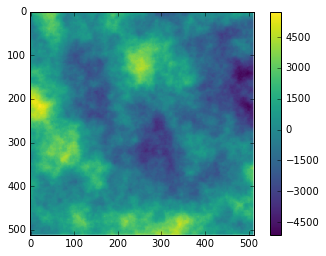

In [17]:
if WITH_ATMOSPHERE:
    atm = ceo.JGmtAtmosphere(**atm_prms)
    atm.r0 = r0
    gs0.timeStamp = 0
    gs0>>(atm,)
    +gs0
    plt.imshow(gs0.phase.host(units='nm'),interpolation='none',cmap='viridis')
    plt.colorbar()
else:
    atm = None

# CALIBRATION

## WFSs

Seeing conversion to FWHM in detector pixel (before binning):

In [18]:
_r0_ = r0*(gs.wavelength/r0_wavelength)**1.2
seeingArcsec = gs.wavelength/_r0_*ceo.constants.RAD2ARCSEC
print "WFS seeing: %.2farcsec"%seeingArcsec
gs_fwhm = round(seeingArcsec/(wfs.camera.pixelScaleArcsec(gs)/wfs.BIN_IMAGE))
print "WFS FWHM: %d pixel"%gs_fwhm
gs.fwhm = gs_fwhm

WFS seeing: 0.75arcsec
WFS FWHM: 5 pixel


### Reference slopes

In [19]:
gs.reset()
gmt.reset()
gmt.propagate(gs)
wfs.calibrate(gs,0.)
print wfs.n_valid_lenslet

6912


In [20]:
print "detector resolution: %dpixel"%wfs.N_PX_FRAME
print "WFS pixel scale:  %.2farcsec"%wfs.pixel_scale_arcsec
print "WFS field-of-view %.2farcsec"%(wfs.pixel_scale_arcsec*wfs.N_PX_IMAGE/wfs.BIN_IMAGE)

detector resolution: 384pixel
WFS pixel scale:  0.42arcsec
WFS field-of-view 3.33arcsec


###  Interaction matrix (decoupled)

The following cell allows to save and to load the WFS interaction matrix

In [21]:
import shelve
db = shelve.open('AGWS_CALIB_DECOUPLED')
#db['C'] = C # uncomment to save 
C = db['C'] # uncomment to load (and comment the line above)
db.close()

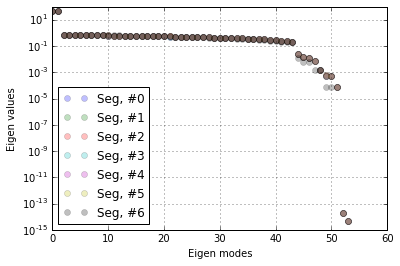

In [22]:
for k in range(7):
    plt.semilogy(C.eigenValues[k],'o',alpha=0.25,label='Seg, #%d'%k)
plt.grid()
plt.legend(loc=0)
plt.xlabel('Eigen modes')
plt.ylabel('Eigen values')

OPTICAL PATH: ['GMT_MX', 'ShackHartmann']
WFS lenslet flux       : 8664.41
# of photon per lenslet: 8558.20
Numerical centroid rms error  : 6.09mas
Theoretical centroid rms error: 6.89mas


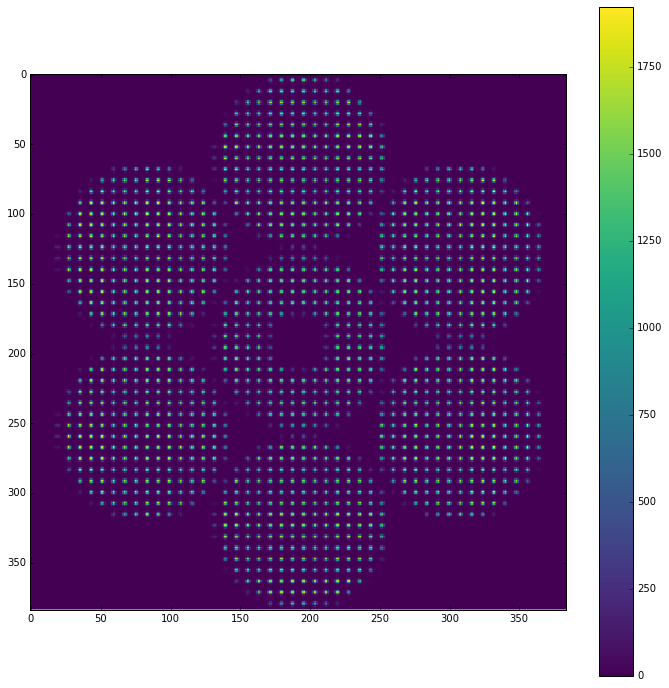

In [23]:
wfs.camera.exposureTime = 30
gs.magnitude = [18]*3
~gmt
~wfs
gs>>(gmt,wfs)
+gs
+wfs
fig = plt.figure()
fig.set_size_inches(12,12)
plt.imshow(wfs.ghost_frame[:wfs.N_PX_FRAME,:],interpolation='none',cmap='viridis')
plt.colorbar()

flux = wfs.flux.host()
print "WFS lenslet flux       : %.2f"%(np.median(flux[flux>0]))
nPhLenslet = wfs.camera.exposureTime*wfs.camera.photoelectron_gain*gs.nPhoton[0]*(26.0/48)**2
print "# of photon per lenslet: %.2f"%(nPhLenslet)

s = wfs.valid_slopes.host(units='mas').ravel()
print "Numerical centroid rms error  : %.2fmas"%(np.std(np.concatenate([s[X.ravel()] for X in C.valid])))
print "Theoretical centroid rms error: %.2fmas"%(1e3*seeingArcsec/np.sqrt(2*np.log(2)*nPhLenslet))

WFS frame read-out noise: 0.500


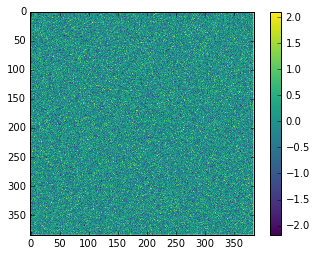

In [24]:
+wfs
fig = plt.figure()
plt.imshow(wfs.ghost_frame[:wfs.N_PX_FRAME,:],interpolation='none',cmap='viridis')
plt.colorbar()
print "WFS frame read-out noise: %.3f"%np.std(wfs.ghost_frame)

Expected # of background photons: 5186050
Measured # of background photons: 5177989


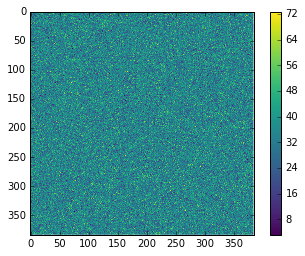

In [25]:
backgroundMagnitude = 16.8
wfs.camera.nBackgroundPhoton = gs.nBackgroundPhoton(backgroundMagnitude)*wfs.camera.pixelScaleArcsec(gs)**2
~wfs
+gs
+wfs
~wfs
+wfs
fig = plt.figure()
plt.imshow(wfs.ghost_frame[:wfs.N_PX_FRAME,:],interpolation='none',cmap='viridis')
plt.colorbar()

print "Expected # of background photons: %.0f"%(gs.nBackgroundPhoton(backgroundMagnitude)*\
                                          wfs.camera.pixelScaleArcsec(gs)**2*\
                                          wfs.camera.exposureTime*wfs.camera.photoelectron_gain)
print  "Measured # of background photons: %.0f"%(np.var(wfs.ghost_frame/wfs_prms['noiseFactor'])*wfs.N_PX_FRAME**2)

## TT7

Seeing conversion to FWHM in detector pixel (before binning):

In [26]:
if TT7_CLASS=='TT7':
    _r0_ = r0*(tt7_gs.wavelength/r0_wavelength)**1.2
    seeingArcsec = tt7_gs.wavelength/_r0_*ceo.constants.RAD2ARCSEC
    print "TT7 seeing: %.2farcsec"%seeingArcsec
    pxscl = tt7.camera.pixelScaleArcsec(tt7_gs)
    tt7_gs_fwhm = round(seeingArcsec/(pxscl/tt7.BIN_IMAGE))
    print "WFS FWHM: %d pixel"%tt7_gs_fwhm
    tt7_gs.fwhm = tt7_gs_fwhm

    print "detector resolution: %dpixel"%tt7.N_PX_FRAME
    print "WFS pixel scale:  %.2farcsec"%pxscl
    print "WFS field-of-view %.2farcsec"%(pxscl*tt7.N_PX_IMAGE/tt7.BIN_IMAGE)

TT7 seeing: 0.75arcsec
WFS FWHM: 259 pixel
detector resolution: 5pixel
WFS pixel scale:  0.41arcsec
WFS field-of-view 2.05arcsec


### Reference slopes

In [27]:
gmt.reset()
gmt.propagate(tt7_gs)
tt7.calibrate(tt7_gs)

### Interaction matrix

In [28]:
%%time
Dtt7 = gmt.calibrate(tt7,tt7_gs,mirror = 'M2',mode='segment tip-tilt',stroke=1e-6)
print Dtt7.shape
print LA.cond(Dtt7)
Mtt7 = LA.inv(Dtt7)

___ M2 ___ (segment tip-tilt)
Segment #:1 2 3 4 5 6 7 
------------
(14, 14)
1.03087386534
CPU times: user 16 s, sys: 8.71 s, total: 24.8 s
Wall time: 24.8 s


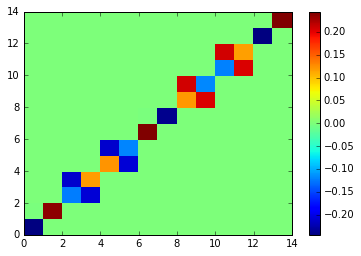

In [29]:
plt.pcolor(Dtt7)
plt.colorbar()

OPTICAL PATH: ['TT7']
[-0.  0. -0.  0.  0. -0. -0.  0. -0. -0. -0. -0.  0.  0.]
WFS total flux     : 13661742.00
# of photon per sec: 14476671.01


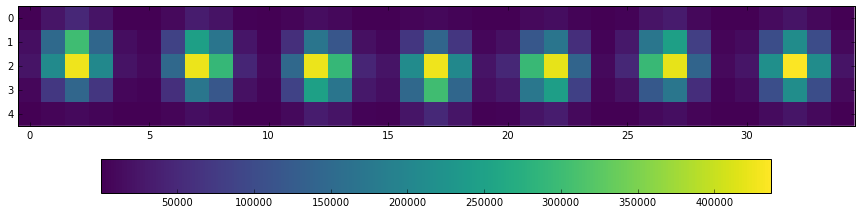

In [30]:
if TT7_CLASS=='TT7':
    tt7.atm =  None
    tt7_gs.fwhm = tt7_gs_fwhm
    tt7_gs>>(tt7,)
    ~gmt
    +tt7_gs
    print np.array_str(tt7.get_measurement()*ceo.constants.RAD2ARCSEC,precision=3,suppress_small=True)
    fig = plt.figure()
    fig.set_size_inches(15,4)
    plt.imshow(np.concatenate([tt7.frames[:,:,k] for k in range(7)],axis=1),interpolation='none',cmap='viridis')
    #plt.imshow(tt7.frames[:,:,k],interpolation='none',cmap='viridis')
    plt.colorbar(orientation='horizontal')

    print "WFS total flux     : %.2f"%tt7.frames.sum()
    print "# of photon per sec: %.2f"%(tt7.camera.photoelectron_gain*tt7_gs.nPhoton*357)

OPTICAL PATH: ['TT7']
[-0.127  0.043 -0.015 -0.012 -0.04   0.115 -0.079  0.041  0.022  0.005
 -0.066  0.109  0.168 -0.042]


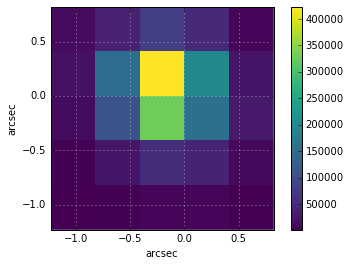

In [31]:
if WITH_ATMOSPHERE:
    tt7.atm = atm
    tt7_gs.timeStamp = 0
    tt7_gs.fwhm = 0
    tt7_gs>>(tt7,)
    ~gmt
    +tt7_gs
    print np.array_str(tt7.get_measurement()*ceo.constants.RAD2ARCSEC,precision=3,suppress_small=True)
    fig = plt.figure()
    ext = np.array([-1,1,-1,1])*tt7.N_PX_FRAME/2*tt7.pixel_scale_arcsec
    plt.imshow(tt7.frames[:,:,0],interpolation='none',cmap='viridis',extent=ext)
    plt.colorbar()
    #plt.xticks(range(-8,10,2))
    #plt.yticks(range(-8,10,2))
    plt.grid(color='w')
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')

# ON AXIS IMAGER

OPTICAL PATH: ['GMT_MX', 'Imaging']
detector resolution: 1001pixel
WFS pixel scale:  2.22mas
WFS field-of-view 2.23arcsec
EE80: 25.94mas


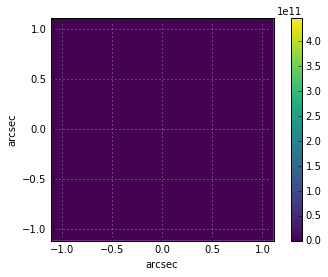

In [33]:
gs0>>(gmt,imgr)
~gmt
~imgr
+gs0
print "detector resolution: %dpixel"%imgr.N_PX_FRAME
print "WFS pixel scale:  %.2fmas"%(imgr.pixelScaleArcsec(gs0)*1e3)
print "WFS field-of-view %.2farcsec"%(imgr.pixelScaleArcsec(gs0)*imgr.N_PX_IMAGE/imgr.BIN_IMAGE)
ext = np.array([-1,1,-1,1])*imgr.N_PX_FRAME*0.5*imgr.pixelScaleArcsec(gs0)
plt.imshow(imgr.frame.host(),interpolation='None',cmap='viridis',extent=ext)
plt.colorbar()
plt.xlabel('arcsec')
plt.ylabel('arcsec')
plt.grid(color='w')
ee80_0 = 1e3*imgr.pixelScaleArcsec(gs0)*imgr.ee80()
print "EE80: %.2fmas"%ee80_0

OPTICAL PATH: ['JGmtAtmosphere', 'GMT_MX', 'Imaging']
EE80: 1346.56mas


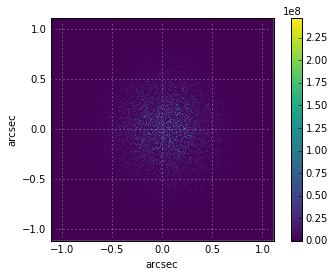

In [38]:
if WITH_ATMOSPHERE:
    gs0>>(atm,gmt,imgr)
    gs0.timeStamp = 0
    ~gmt
    ~imgr
    +gs0
    plt.imshow(imgr.frame.host(),interpolation='None',cmap='viridis',extent=ext)
    plt.colorbar()
    plt.grid(color='w')
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    ee80_atm = 1e3*imgr.pixelScaleArcsec(gs0)*imgr.ee80()
    print "EE80: %.2fmas"%ee80_atm

OPTICAL PATH: ['JGmtAtmosphere', 'GMT_MX', 'Imaging']
EE80: 1313.47mas
Guide star time stamp:200s
CPU times: user 8.82 s, sys: 3.49 s, total: 12.3 s
Wall time: 12.3 s


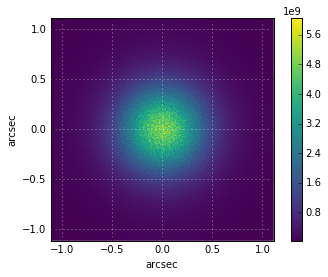

In [34]:
%%time
if WITH_ATMOSPHERE:
    nStep = 200
    ps0_rms_0 = np.zeros(nStep)
    gmt0 = ceo.GMT_MX()
    ~imgr
    gs0>>(atm,gmt0,imgr)
    gs0.timeStamp = 0
    for k in range(nStep):
        +gs0
        ps0_rms_0[k] = gs0.wavefront.rms(-9)

    psf_atm_0 = imgr.frame.host()
    ee80_atm_0 = 1e3*imgr.pixelScaleArcsec(gs0)*imgr.ee80()
    print "EE80: %.2fmas"%ee80_atm_0
    
    plt.imshow(imgr.frame.host(),interpolation='None',cmap='viridis',extent=ext)
    plt.colorbar()
    plt.grid(color='w')
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    print "Guide star time stamp:%gs"%gs0.timeStamp

# AGWS CLOSED-LOOP

In [35]:
def updateGMT(__c__,_dist_,__tt7_c__=0.0):
    _s_ = np.s_[:]
    l = 12+gmt.M1.modes.n_mode
    cp = np.reshape(__c__,(7,l))
    gmt.M1.motion_CS.update(Rxyz=(_s_,_s_,_dist_[0] - cp[:,:3]),
                            Txyz=(_s_,_s_,_dist_[2] - cp[:,3:6]))
    gmt.M2.motion_CS.update(Rxyz=(_s_,_s_,_dist_[1] - __tt7_c__ - cp[:,6:9]),
                            Txyz=(_s_,_s_,_dist_[3] - cp[:,9:12]))
    gmt.M1.modes.a[:] = _dist_[4] - cp[:,12:]
    gmt.M1.modes.update()

In [36]:
from numpy.random import randn
def perturbations():
    M1_Txyz0      = randn(7,3)*75e-6;
    M1_Txyz0[:,2] = randn(7)*160e-6;
    M1_Txyz0[6,2] = 0; #% M1 S1 Tz

    M2_Txyz0      = randn(7,3)*75e-6;
    M2_Txyz0[:,2] = randn(7)*170e-6;

    arcs2rad = np.pi/180/3600;
    M1_Rxyz0      = randn(7,3)*0.38*arcs2rad;
    M1_Rxyz0[:,2] = randn(7)*40*arcs2rad;

    M2_Rxyz0      = randn(7,3)*3.0*arcs2rad;
    M2_Rxyz0[:,2] = randn(7)*330*arcs2rad;

    #M1_RiBo_d = M1_Txyz0 M1_Rxyz0]; 
    #M2_RiBo_d = [M2_Txyz0 M2_Rxyz0];

    radialOrders = np.concatenate( [np.ones((1,x+1))*x for x in range(9)] , axis=1 )
    scale = 1.0/radialOrders[0,3:];
    M1_BeMo_d = 1e-6*randn(7,gmt.M1.modes.n_mode)*scale[None,:]/scale[0];
    
    return (M1_Rxyz0,M2_Rxyz0,M1_Txyz0,M2_Txyz0,M1_BeMo_d)

## Setting the optical paths

In [37]:
~gmt
~wfs
~imgr
~gs0
~gs
~tt7_gs
if WITH_ATMOSPHERE:
    gs0>>(atm,gmt,imgr)
    
    gs.fwhm = 0
    gs>>(atm,gmt,wfs)
    
    tt7.atm = atm
    tt7_gs.fwhm = 0
    tt7_gs>>(tt7,)
else:
    gs0>>(gmt,imgr)
    
    gs.fwhm = gs_fwhm
    gs>>(gmt,wfs)    
    
    if TT7_CLASS=='TT7':
        tt7.atm = None
        tt7_gs.fwhm = tt7_gs_fwhm
        tt7_gs>>(tt7,)
    if TT7_CLASS=='GeometricTT7':
        tt7_gs>>(gmt,tt7,)

OPTICAL PATH: ['JGmtAtmosphere', 'GMT_MX', 'Imaging']
OPTICAL PATH: ['JGmtAtmosphere', 'GMT_MX', 'ShackHartmann']
OPTICAL PATH: ['TT7']


## Setting the # of background photons

In [38]:
backgroundMagnitude = 16.8 # per arcsec^2, 30 deg. from full moon
#backgroundMagnitude = 19.7 # per arcsec^2, 60 deg. from full moon
+gs
wfs.camera.nBackgroundPhoton = gs.nBackgroundPhoton(backgroundMagnitude)*wfs.camera.pixelScaleArcsec(gs)**2
print "WFS # of background photon per frame: %.0f"%wfs.camera.nBackgroundPhoton
if TT7_CLASS=="TT7":
    +tt7_gs
    tt7.camera.nBackgroundPhoton = tt7_gs.nBackgroundPhoton(backgroundMagnitude)*tt7.camera.pixelScaleArcsec(tt7_gs)**2
    print "TT7 # of background photon per frame: %.0f"%tt7.camera.nBackgroundPhoton

WFS # of background photon per frame: 274394
TT7 # of background photon per frame: 37692


## Simulation sampling time, WFSs exposure and simulation duration [s]

In [39]:
samplingTime = 1/200.0
wfsExposureTime = 5
simDuration = 25

## Segments initial perturbations:

In [40]:
if WITH_MISALIGNMENT:
    dist = perturbations()
else:
    dist = [np.zeros((7,3)) for k in range(4)] + [np.zeros((7,42))]

In [41]:
gmt.reset()
gmt.M1.motion_CS.euler_angles[:] = dist[0]
gmt.M1.motion_CS.origin[:]       = dist[2]
gmt.M1.motion_CS.update()
gmt.M2.motion_CS.euler_angles[:] = dist[1]
gmt.M2.motion_CS.origin[:]       = dist[3]
gmt.M2.motion_CS.update()
gmt.M1.modes.a[:] = dist[4]
gmt.M1.modes.update()

### Initial WFE RMS [nm]:

In [42]:
gs0.timeStamp = 0
+gs0
print gs0.wavefront.rms(-9)

[ 1671.347718]


## Guide star magnitude

In [43]:
tt7_gs.magnitude = [18]
gs.magnitude = [18]*3

### Wavefront sensor #1 initial frame

 >>> WFS lenslet flux       : 8364.30
 >>> # of photon per lenslet: 8150.67
 >>> Numerical centroid rms error: 170.55mas
CPU times: user 334 ms, sys: 118 ms, total: 452 ms
Wall time: 452 ms


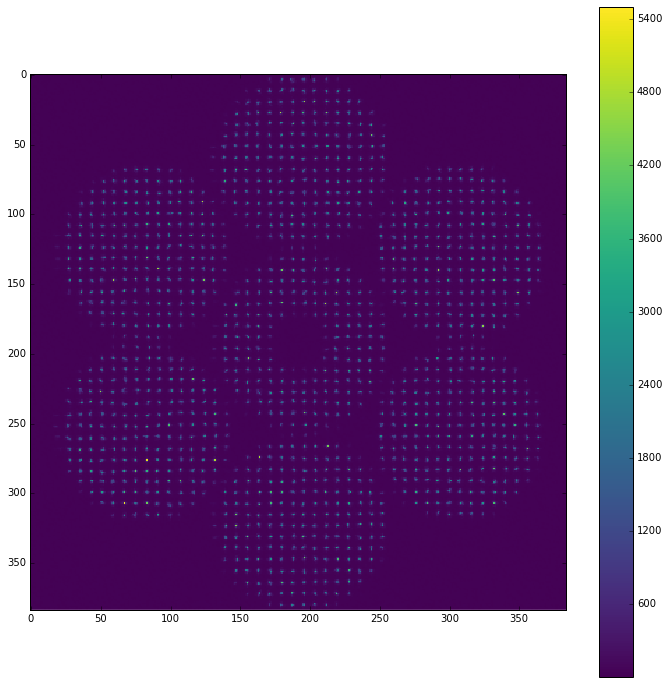

In [44]:
%%time
gs.timeStamp = 0
wfs.camera.exposureTime = 30#wfsExposureTime
~wfs
+gs
+wfs
fig = plt.figure()
fig.set_size_inches(12,12)
plt.imshow(wfs.ghost_frame[:wfs.N_PX_FRAME,:],interpolation='none',cmap='viridis')
plt.colorbar()

flux = wfs.flux.host()
print " >>> WFS lenslet flux       : %.2f"%(np.median(flux[flux>0]))
print " >>> # of photon per lenslet: %.2f"%(wfs.camera.exposureTime*wfs.camera.photoelectron_gain*gs.nPhoton[0]*(26.0/48)**2)

s = wfs.valid_slopes.host(units='mas').ravel()
print " >>> Numerical centroid rms error: %.2fmas"%(np.std(np.concatenate([s[X.ravel()] for X in C.valid])))

### Wavefront sensor long exposure frame

 >>> WFS lenslet flux       : 41729.21
 >>> # of photon per lenslet: 51427.23
 >>> Numerical centroid rms error  : 14.14mas
CPU times: user 21min 2s, sys: 11min 25s, total: 32min 28s
Wall time: 32min 28s


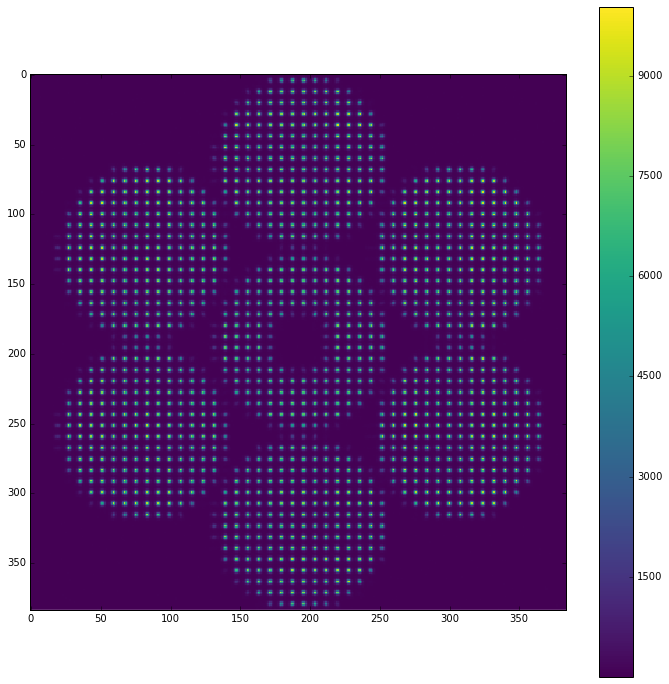

In [ ]:
%%time
gs.timeStamp = 0
gs.samplingTime = samplingTime
wfs.camera.exposureTime = 30#exposureTime
~wfs
gs+=6000
+wfs
fig = plt.figure()
fig.set_size_inches(12,12)
plt.imshow(wfs.ghost_frame[:wfs.N_PX_FRAME,:],interpolation='none',cmap='viridis')
plt.colorbar()

flux = wfs.flux.host()
print " >>> WFS lenslet flux       : %.2f"%(np.median(flux[flux>0]))
print " >>> # of photon per lenslet: %.2f"%(wfs.camera.exposureTime*wfs.camera.photoelectron_gain*gs.nPhoton[0]*(26.0/48)**2)

s = wfs.valid_slopes.host(units='mas').ravel()
print " >>> Numerical centroid rms error  : %.2fmas"%(np.std(np.concatenate([s[X.ravel()] for X in C.valid])))

### TT7 sensor initial frame

WFS total flux     : 1121.24
# of photon per sec: 826.45
CPU times: user 568 ms, sys: 243 ms, total: 811 ms
Wall time: 811 ms


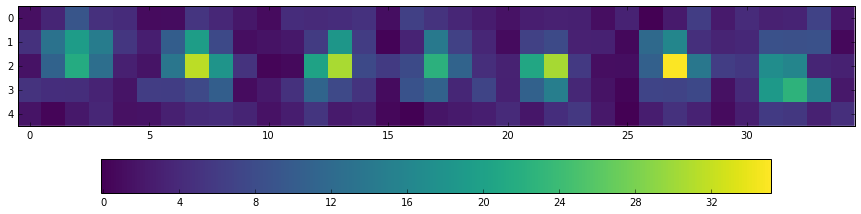

In [45]:
%%time
if TT7_CLASS=="TT7":
    tt7_gs.timeStamp = 0 
    tt7.camera.exposureTime = samplingTime
    +tt7_gs
    fig = plt.figure()
    fig.set_size_inches(15,4)
    plt.imshow(np.concatenate([tt7.frames[:,:,k] for k in range(7)],axis=1),interpolation='none',cmap='viridis')
    #plt.imshow(tt7.frames[:,:,k],interpolation='none',cmap='viridis')
    plt.colorbar(orientation='horizontal')

    print "WFS total flux     : %.2f"%tt7.frames.sum()
    print "# of photon per sec: %.2f"%(tt7.camera.exposureTime*tt7.camera.photoelectron_gain*tt7_gs.nPhoton*357)

## Integrator gains

In [46]:
wfs_loop_gain = 0.2
tt7_loop_gain = 0.2

## Number of sensor frame delays

In [47]:
wfs_nFrameDelay = 1
tt7_nFrameDelay = 1

In [48]:
VISU = False

In [49]:
%%time
print time.asctime( time.localtime(time.time()) )

gs0.timeStamp = 0
gs.timeStamp = 0
tt7_gs.timeStamp = 0
gs.samplingTime = samplingTime
gs0.samplingTime = samplingTime
tt7_gs.samplingTime = samplingTime

nStep = int(simDuration/samplingTime)
nFrame = int(wfsExposureTime/samplingTime)
print "nStep=%d ; nFrame=%d"%(nStep,nFrame)

ps0_rms = np.zeros(nStep)

tt7_c = np.zeros(14)
tt7_c_eps = np.zeros((14,1+tt7_nFrameDelay))
l = 12+gmt.M1.modes.n_mode
c = np.zeros((7*l,1))
c_eps = np.zeros((7*l,1+wfs_nFrameDelay))

tt7_stt = []
stt = []

gmt.M2.motion_CS.log = 0
~imgr
~wfs

if VISU:
    fig,(ax1,ax2) = plt.subplots(ncols=2)
    fig.set_size_inches(15,6)

for k in range(nStep):

    sys.stdout.write("\rT=%.3fs"%(k*samplingTime))
    sys.stdout.flush()
    
    gs0.timeStamp = k*samplingTime
    gs.timeStamp = k*samplingTime
    tt7_gs.timeStamp = k*samplingTime

    stt.append( gs0.segmentsWavefrontGradient().host(units='arcsec') )
    if k>=nFrame:
        #sys.stdout.write("WFS first integration @ T=%.3fs\n"%(k*samplingTime))
        +gs
    +tt7_gs

    #sys.stdout.write("WFE RMS %gnm\n"%(ps0_rms[k]) )

    tt7_s = tt7.get_measurement()
    tt7_stt.append(tt7_s)
    tt7__c_ = np.dot(Mtt7,tt7_s)
    
    tt7_c_eps = np.roll(tt7_c_eps,1,axis=1)
    tt7_c_eps[:,0] = tt7__c_
    
    tt7_c = tt7_c + tt7_loop_gain*tt7_c_eps[:,tt7_nFrameDelay]
    tt7_cp = np.append( tt7_c.reshape(7,2) , np.zeros((7,1)) , axis =1 )
    

    if (k>=2*nFrame) and (k%nFrame)==0:

        sys.stdout.write("\rWFS readout @ T=%.3fs"%(k*samplingTime))
        sys.stdout.flush()
        +wfs
        s = wfs.valid_slopes.host(shape=(wfs.n_valid_slopes,1))
        _c_ = C.dot(s)
    
    if (k>=2*nFrame) and (k%(nFrame+wfs_nFrameDelay))==0:

        c = c + wfs_loop_gain*_c_

    updateGMT(c[:,0],dist,tt7_cp)
    
    if (k>=tt7_nFrameDelay):
        #~imgr
        +gs0
        ps0_rms[k] = gs0.wavefront.rms(-9)
        psf_atm_aco = imgr.frame.host()
        ee80 = 1e3*imgr.pixelScaleArcsec(gs0)*imgr.ee80()
        
        if np.isnan(ps0_rms[k]):
            print " >>> NAN ISSUE!!"
            break

        if VISU:
            fwhm8 = (gs0.wavelength/8)*ceo.constants.RAD2ARCSEC
            o = np.linspace(0,1,21)*2*np.pi
            x8 = 0.5*fwhm8*np.cos(o)
            y8 = 0.5*fwhm8*np.sin(o)

            ext = np.array([-1,1,-1,1])*imgr.N_PX_FRAME*0.5*imgr.pixelScaleArcsec(gs0)
            h1 = ax1.imshow(psf_atm_aco,interpolation='none',cmap='viridis',extent=ext)
            ax1.set_title("EE80 %.2fmas"%(ee80))
            ax1.plot(x8,y8,'w:', linewidth=0.5)
            ax1.grid(color='w')
            ax1.set_xlabel('arcsec')
            ax1.set_ylabel('arcsec')
            clb1 = plt.colorbar(h1,ax=ax1)

            h2 = ax2.imshow(gs0.phase.host(units='nm'),interpolation='none',cmap='viridis')
            clb2 = plt.colorbar(h2,ax=ax2,label='WFE [nm]')
            ax2.set_title("WFE RMS: %.2fnm"%ps0_rms[k])
            ax2.set_xticks([])
            ax2.set_yticks([])

            clear_output(wait=True)
            display(fig)
            clb1.remove()
            clb2.remove()

sys.stdout.write("\n\n")
if VISU:
    plt.close()

Sun Feb  5 21:34:55 2017
nStep=5000 ; nFrame=1000
T=24.995s

CPU times: user 2h 22min 37s, sys: 35min 44s, total: 2h 58min 22s
Wall time: 2h 58min 12s


In [50]:
35*6/60

3

[]

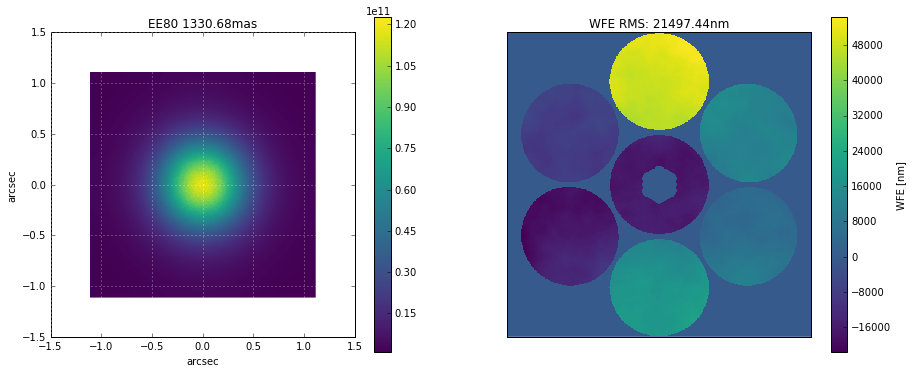

In [50]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,6)

fwhm8 = (gs0.wavelength/8)*ceo.constants.RAD2ARCSEC
o = np.linspace(0,1,21)*2*np.pi
x8 = 0.5*fwhm8*np.cos(o)
y8 = 0.5*fwhm8*np.sin(o)

ext = np.array([-1,1,-1,1])*imgr.N_PX_FRAME*0.5*imgr.pixelScaleArcsec(gs0)
h1 = ax1.imshow(psf_atm_aco,interpolation='none',cmap='viridis',extent=ext)
ax1.set_title("EE80 %.2fmas"%(ee80))
ax1.plot(x8,y8,'w:', linewidth=0.5)
ax1.grid(color='w')
ax1.set_xlabel('arcsec')
ax1.set_ylabel('arcsec')
clb1 = plt.colorbar(h1,ax=ax1)

h2 = ax2.imshow(gs0.phase.host(units='nm'),interpolation='none',cmap='viridis')
clb2 = plt.colorbar(h2,ax=ax2,label='WFE [nm]')
ax2.set_title("WFE RMS: %.2fnm"%ps0_rms[k])
ax2.set_xticks([])
ax2.set_yticks([])


In [51]:
np.isnan(ps0_rms[-1])

False

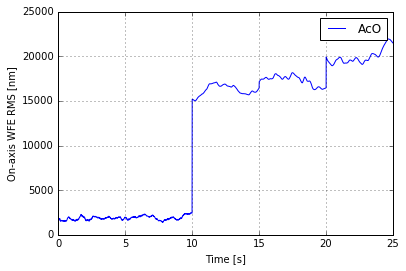

In [52]:
u = np.arange(nStep)*samplingTime
plt.plot(u,ps0_rms.ravel(),label='AcO')
#plt.plot(u,ps0_rms_0.ravel(),label='On-axis')
#plt.plot(tt7_ps0_rms_0.ravel(),label='TT7')
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('On-axis WFE RMS [nm]')
plt.legend(loc='best')

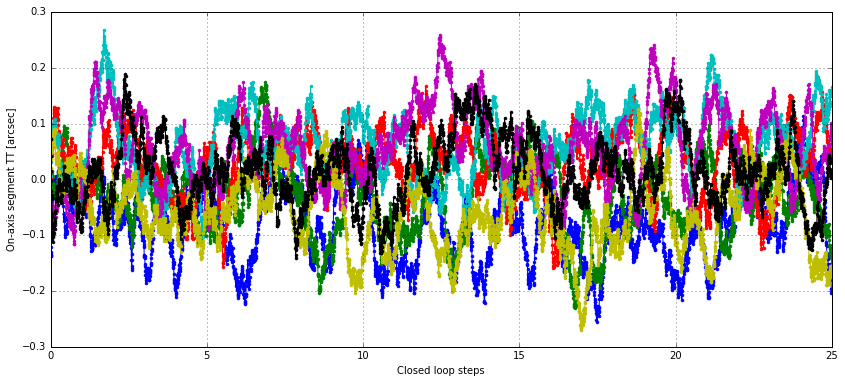

In [53]:
fig = plt.figure(figsize=(14,6))
stt_ = np.concatenate(stt,axis=1).T
plt.plot(u,stt_[:,:7],'.-')
#plt.plot([0,45],np.tile(tt7.reference_slopes[:,0].T*ceo.constants.RAD2ARCSEC,2).reshape(2,14))
#plt.xlim([0,45])
#plt.ylim([-0.1,0.1])
plt.grid()
plt.xlabel('Closed loop steps')
plt.ylabel('On-axis segment TT [arcsec]')

# REFERENCE ATMOSPHERE PSF 

In [ ]:
%%time
ps0_rms_0 = np.zeros(nStep)
gmt0 = ceo.GMT_MX()
~imgr
gs0>>(atm,gmt0,imgr)
gs0.timeStamp = 0
for k in range(nStep):
    +gs0
    ps0_rms_0[k] = gs0.wavefront.rms(-9)

psf_atm_0 = imgr.frame.host()
ee80_atm_0 = 1e3*imgr.pixelScaleArcsec(gs0)*imgr.ee80()

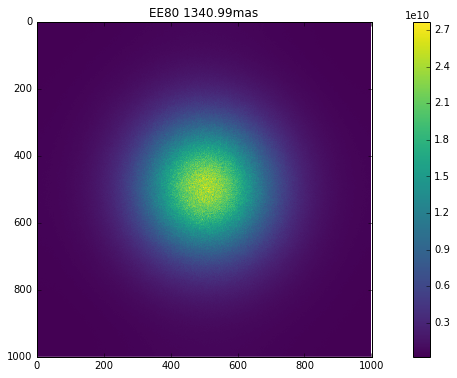

In [63]:
fig,ax1 = plt.subplots()
fig.set_size_inches(15,6)
h1 = ax1.imshow(psf_atm_0,interpolation='none',cmap='viridis')
ax1.set_title("EE80 %.2fmas"%(ee80_atm_0))
plt.colorbar(h1,ax=ax1)
#ax1.set_xticks([])
#ax1.plot(x8,y8,'w:')


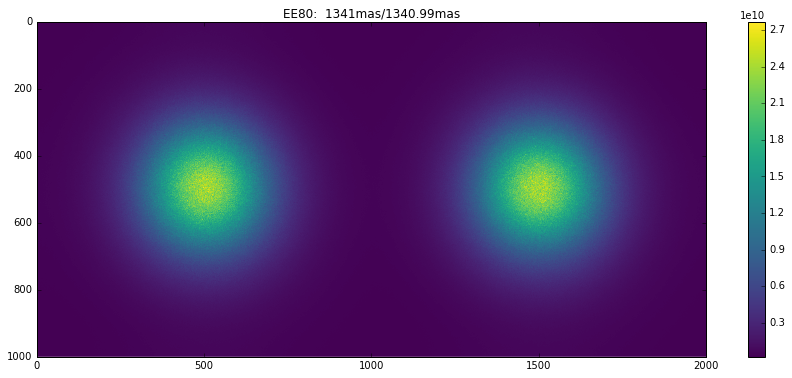

In [64]:
fig,ax1 = plt.subplots()
fig.set_size_inches(15,6)
h1 = ax1.imshow(np.concatenate([psf_atm_0,psf_atm_aco],axis=1),interpolation='none',cmap='viridis')
ax1.set_title("EE80:  %2.fmas/%.2fmas"%(ee80_atm_0,ee80))
plt.colorbar(h1,ax=ax1)
#ax1.set_xticks([])
#ax1.plot(x8,y8,'w:')


In [65]:
print np.sum(psf_atm_0)
print np.sum(psf_atm_aco)

3.16718e+15
3.16397e+15


In [66]:
np.sum(psf_atm_aco**2)/np.sum(psf_atm_0**2)

0.99756962

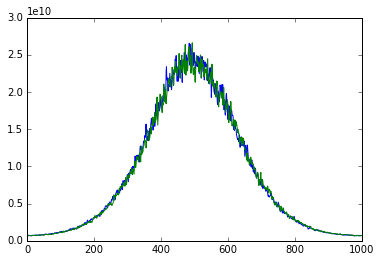

In [67]:
plt.plot(psf_atm_0[:,500])
plt.plot(psf_atm_aco[:,500])


In [68]:
from scipy.signal import medfilt

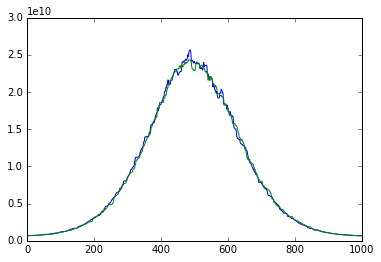

In [69]:
kern = 11
plt.plot(medfilt(psf_atm_0[:,500],kern))
plt.plot(medfilt(psf_atm_aco[:,500],kern))
#plt.ylim([0,1e9])